In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

# Function to load and preprocess images from a directory
def load_images_from_directory(directory, img_size=(224, 224)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(img_size)  # Resize image
            img = np.array(img) / 255.0  # Normalize pixel values
            images.append(img)
    return np.array(images)

# Define the directories
train_data_dir = '/content/drive/MyDrive/train/Normal'
test_data_dir_normal = '/content/drive/MyDrive/test/NORMAL'
test_data_dir_pneumonia = '/content/drive/MyDrive/test/PNEUMONIA'

# Load and preprocess the images
train_images = load_images_from_directory(train_data_dir)
test_images_normal = load_images_from_directory(test_data_dir_normal)
test_images_pneumonia = load_images_from_directory(test_data_dir_pneumonia)

# Convert them to TensorFlow datasets (optional)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(32)
test_dataset_normal = tf.data.Dataset.from_tensor_slices(test_images_normal).batch(32)
test_dataset_pneumonia = tf.data.Dataset.from_tensor_slices(test_images_pneumonia).batch(32)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Set the image dimensions and latent space size
img_height, img_width, img_channels = 224, 224, 1  # Grayscale images have 1 channel
latent_dim = 64  # Size of the latent space

class Autoencoder(Model):
    def __init__(self, latent_dim, img_shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=img_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(28 * 28 * 128, activation='relu'),
            layers.Reshape((28, 28, 128)),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(img_channels, (3, 3), activation='sigmoid', padding='same')
        ])

    # Call method defines how the autoencoder will be called (forward pass)
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Define image shape
img_shape = (img_height, img_width, img_channels)

# Instantiate the autoencoder
autoencoder = Autoencoder(latent_dim, img_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Model summary
autoencoder.build(input_shape=(None, img_height, img_width, img_channels))
autoencoder.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 64)                  │       6,515,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 1)         │       6,763,009 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,278,273 (50.65 MB)

 Trainable params: 13,278,273 (50.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Print the number of images in each dataset (train, normal test, pneumonia test)
print(f"Number of training images: {train_images.shape[0]}")
print(f"Number of normal test images: {test_images_normal.shape[0]}")
print(f"Number of pneumonia test images: {test_images_pneumonia.shape[0]}")


Number of training images: 1100
Number of normal test images: 234
Number of pneumonia test images: 390


In [ ]:
history=autoencoder.fit(train_images,train_images,
                        epochs=20,batch_size=64,
                        validation_data=(test_images_normal,test_images_normal),
                        shuffle=True)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 307s 17s/step - loss: 0.0455 - val_loss: 0.0249
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 318s 17s/step - loss: 0.0209 - val_loss: 0.0237
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 323s 17s/step - loss: 0.0192 - val_loss: 0.0199
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 293s 16s/step - loss: 0.0174 - val_loss: 0.0196
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 296s 16s/step - loss: 0.0163 - val_loss: 0.0187
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 321s 16s/step - loss: 0.0159 - val_loss: 0.0178
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 327s 17s/step - loss: 0.0146 - val_loss: 0.0157
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 311s 16s/step - loss: 0.0136 - val_loss: 0.0148
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 331s 17s/step - loss: 0.0119 - val_loss: 0.0136
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step - loss: 0.0105 - val_loss: 0.0131
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 323s 16s/step - loss: 0.0099 - val_loss: 0.0118
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step

In [ ]:
# Save the entire model
autoencoder.save('/content/drive/MyDrive/my_project/autoencoder_model_Xray.h5')

# Later, load the model back
#loaded_autoencoder = tf.keras.models.load_model('autoencoder_model.h5')


In [ ]:
decoded_data = autoencoder.predict(test_images_normal)

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


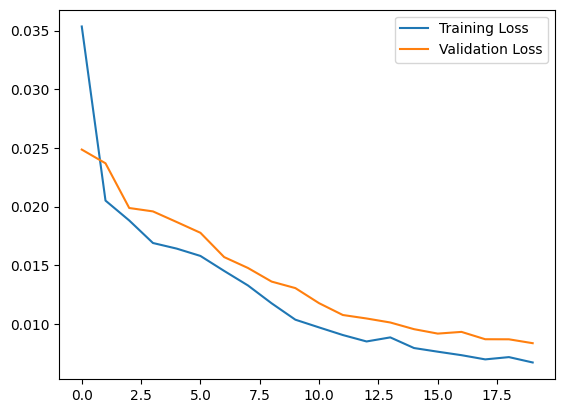

In [ ]:
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


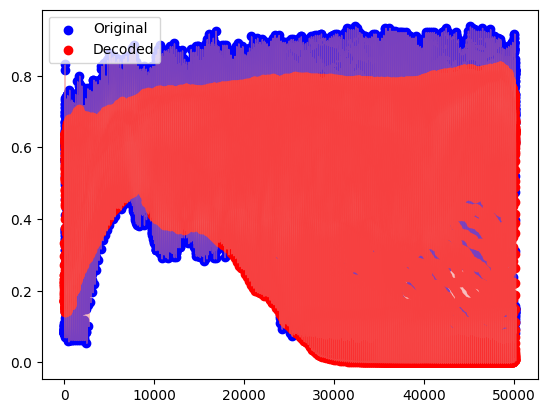

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the original and decoded images
original_image = test_images_normal[0].flatten()  # Flatten the original image
decoded_image = decoded_data[0].flatten()  # Flatten the decoded image

# Plot using scatter
plt.scatter(np.arange(len(original_image)), original_image, color='b', label='Original')
plt.scatter(np.arange(len(decoded_image)), decoded_image, color='r', label='Decoded')
plt.fill_between(np.arange(len(original_image)), decoded_image, original_image, color="lightcoral", alpha=0.5)
plt.legend()
plt.show()


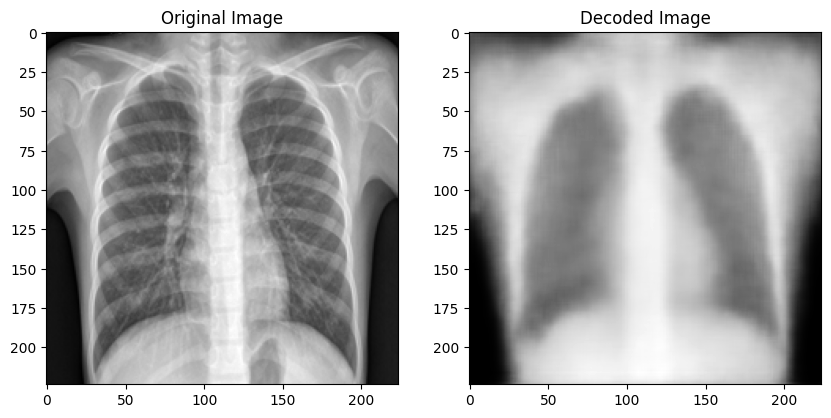

In [ ]:
# Display original and decoded images using imshow
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(test_images_normal[0].reshape(img_height, img_width), cmap='gray')
axes[0].set_title('Original Image')

# Decoded image
axes[1].imshow(decoded_data[0].reshape(img_height, img_width), cmap='gray')
axes[1].set_title('Decoded Image')

plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


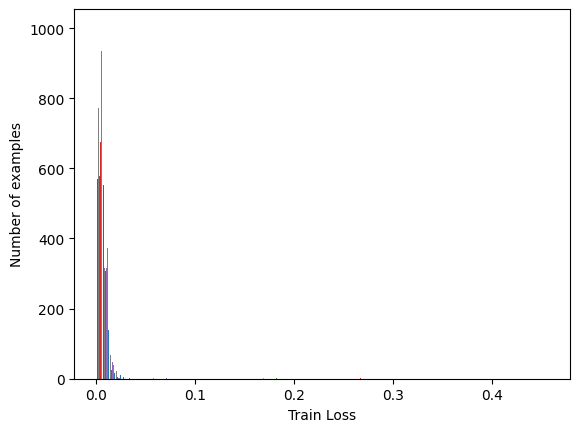

In [ ]:
## Predict on normal training data
reconstruction = autoencoder.predict(train_images)

# Compute MSE loss for each sample
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mae=tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
train_loss = mse(train_images, reconstruction)
train_loss2=mae(train_images, reconstruction)
#print(train_loss)
#print(train_loss2)
# Convert the loss to a NumPy array
train_loss_np = train_loss.numpy()
train_loss2_np = train_loss2.numpy()
# Plot histogram
plt.hist(train_loss_np, bins=70)
plt.xlabel("Train Loss")
plt.ylabel("Number of examples")
plt.show()


In [ ]:
threshold=np.mean(train_loss) + np.std(train_loss)
threshold2=np.mean(train_loss2) + np.std(train_loss2)
loss_s=np.mean(train_loss)
print("Threshold:" ,threshold)
print("Threshold2:",threshold2)

Threshold: 0.0125923455
Threshold2: 0.0748983


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
tf.Tensor(
[0.09163056 0.09646041 0.0964836  0.09403931 0.0939978  0.08829574
 0.08563899 0.08779236 0.0814187  0.08107916 0.07727771 0.07744296
 0.07576329 0.07482623 0.06965944 0.0677292  0.06775101 0.07295604
 0.07507326 0.07754336 0.08325756 0.08155564 0.08196332 0.08181853
 0.08028625 0.07926697 0.07815723 0.07812985 0.07830911 0.0781476
 0.07509762 0.0701874  0.06843719 0.06693397 0.06328995 0.06042738
 0.06501511 0.06750438 0.06873359 0.07069726 0.07180606 0.07160943
 0.07144963 0.07019145 0.06740794 0.06445023 0.06278364 0.06143462
 0.06081855 0.06261732 0.06414495 0.06599011 0.06558596 0.06446087
 0.06657387 0.06989271 0.07093675 0.07139488 0.06978953 0.06747772
 0.06567081 0.06568341 0.06283326 0.06164088 0.06224737 0.06174858
 0.06076637 0.06134553 0.0643236  0.06407203 0.06458662 0.06345383
 0.06385272 0.06883965 0.06588923 0.0642553  0.06697202 0.06796003
 0.06888789 0.06792145 0.06553224 0.06463605 0.06081345 0.05751806
 0.05665318 0

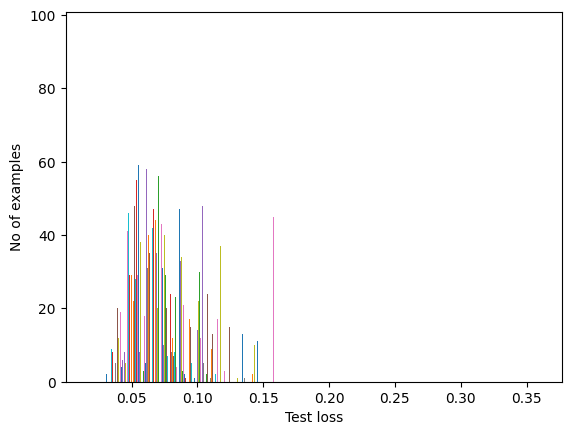

In [ ]:
reconstructions = autoencoder.predict(test_images_pneumonia)
test_loss = mae(reconstructions, test_images_pneumonia)
print(test_loss[0])
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def calculate_loss(model, data):
    reconstructions = model(data)
    mae = tf.keras.losses.MeanAbsoluteError()
    loss = mae(tf.keras.backend.flatten(data), tf.keras.backend.flatten(reconstructions))
    return loss
def predict_anomalies(model, data, threshold2):
    loss = calculate_loss(model, data)
    if loss > threshold2:
     return 1 and print("Anomaly Detected")
    else:
     return 0 and print("Normal")
    predictions = tf.math.greater(loss, threshold).numpy()
    return predictions

In [ ]:
predict_anomalies(autoencoder,test_images_pneumonia,threshold)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Function to calculate reconstruction loss (e.g., MSE)
def calculate_loss(model, data):
    reconstructions = model(data)
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(tf.keras.backend.flatten(data), tf.keras.backend.flatten(reconstructions))
    return loss

# Function to predict anomalies based on the threshold
def predict_anomalies(model, data, threshold):
    loss = calculate_loss(model, data)
    # Anomaly if loss > threshold (return 1 for anomaly, 0 for normal)
    predictions = tf.math.greater(loss, threshold).numpy()
    return predictions

# Function to evaluate model accuracy
def evaluate_autoencoder(model, normal_data, anomaly_data, threshold):
    # Predict for normal and anomaly data
    normal_predictions = predict_anomalies(model, normal_data, threshold)
    anomaly_predictions = predict_anomalies(model, anomaly_data, threshold)

    # True labels (0 for normal, 1 for anomaly)
    true_labels = np.concatenate([np.zeros(len(normal_predictions)), np.ones(len(anomaly_predictions))])

    # Predicted labels (0 for normal, 1 for anomaly)
    predicted_labels = np.concatenate([normal_predictions, anomaly_predictions])

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# Example usage

evaluate_autoencoder(autoencoder, test_images_normal, test_images_pneumonia, threshold)
